### Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_datareader.data as web
from datetime import datetime as dt
import matplotlib.dates as mdates
import statsmodels.formula.api as smf
import os

from matplotlib.ticker import FuncFormatter

### Create a Function to Grab the Data

In [2]:
# Define relative file path
filepath = os.getcwd() + '\\'

# Define a function to grab tax data by return type, tax weight, and upper/lower bound
def DataGrabber(return_selection, upper_bound = 100, lower_bound= -1):
    all_data = pd.DataFrame()
    
    # Define years and column names
    years = ['96', '97', '98', '99', '00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20']
    offyears = ['96', '97', '98', '99']
    colnames = ['tax_rate', 'number_of_returns', 'income_taxed', 'tax_generated', 'year']
    
    initialcolnames = ['Tax rate', 'All returns', 'Unnamed: 2', 'Unnamed: 3',
       'Married Filed Jointly', 'Unnamed: 5', 'Unnamed: 6',
       'Married Filed Separately', 'Unnamed: 8', 'Unnamed: 9',
       'Heads of Household', 'Unnamed: 11', 'Unnamed: 12',
       'Returns of Single', 'Unnamed: 14', 'Unnamed: 15']
    
    for year in years:
        # Load the data and skip initial unnecessary rows
        data = pd.read_excel(filepath + '{0}in36tr.xlsx'.format(year), skiprows = 3)
        
        # This ensures each data pull has the same column names for referencing (some have variations in spelling in the original data)
        data.columns = initialcolnames
        
        # Add a year column
        if year in offyears :
             data['year'] = '19{0}'.format(year)
        else:
             data['year'] = '20{0}'.format(year)

        # Get a boolean vector that has True for the index where the column name is equal to the return selection type (e.g, 'All returns')
        col_index = data.columns.str.contains(return_selection)

        # Create a list of columns to grab using colselect as a reference (note: for each return type, the next two columns are data for that return selection type)
        cols_to_grab = [[0, i, i+1, i+2] for i, x in enumerate(col_index) if x]
        [cols_to_grab] = cols_to_grab
        
        # This adds a number one less than the length which will grab the 'year' column, as it's the newest
        cols_to_grab.append(len(data.columns)-1)

        # Convert the columns to the actual string names
        cols_to_grab = data.columns[cols_to_grab].tolist()
        
        # Replace all asterisks and commas in the numbers of the data so they can be converted to float
        data = data.applymap(lambda x: str(x).replace('*', ''))
        data = data.applymap(lambda x: str(x).replace(',', ''))

        # Grab a subset of the data using the columns and rename. Remove rows with unnecssary data (interpretted as NA)
        data = data.loc[:, cols_to_grab].dropna()
        data.columns = colnames
        
        # If you look inside the excel data, the tax rate column has rates like '10 percent (capital gains)', this removes data like that keeping only marginal rates
        data = data.loc[(data['tax_rate'].str.contains('percent')) & (~data['tax_rate'].str.contains('\('))].copy()

        # Strip the data of spaces and convert to float, convert the year, and set index
        data['tax_rate'] = data['tax_rate'].str.replace(' percent', '')
        data['tax_rate'] = data['tax_rate'].str.strip()
        data['year'] = pd.to_datetime(data['year'])
        data.set_index('year', inplace = True)

        # Convert the rest of the data to float type
        for cols in data.columns.tolist():
             data[cols] = data[cols].astype(float)
        
        # This section determine the subset of your data based on the upper and lower marginal tax rates you give it
        data = data.loc[data['tax_rate'] <= upper_bound]
        data = data.loc[data['tax_rate'] >= lower_bound]

        # Weight the tax rate by the income taxed. This gives a higher rate to groups with greater taxed income relative to returns. 
            ## Note: Sqrt is used to handle the dramatic size difference between the lower, middle, and upper income brackets
        data['weight_factor'] = data['income_taxed']/np.sqrt(data['number_of_returns'])
        data['weight_factor'] = data['weight_factor']/data['weight_factor'].sum()
        data['weighted_rate'] = data['weight_factor']*data['tax_rate']   
        
        # Create a dataframe that holds all the loaded data
        all_data = pd.concat([all_data, data])
    
    return all_data

### Load FRED Data from 1996. Normalize to 2019 dollars

In [3]:
# Load PCE and GDP data from the FRED api
codes = ['PCE', 'GDPC1']
fred = web.DataReader(codes, 'fred', start='1996-01-01')

# Drop NA rows, and resample to a year level (the 'AS' resamples to Jan 1st of that year). Finally, normalize the PCE to 2019 dollars
fred = fred.dropna()
fred = fred.resample('AS').mean()
fred['PCE'] = fred['PCE']/fred.loc['2019', 'PCE'][0]

### Merges FRED and Tax Data

In [4]:
# Create a dictionary that is plugged into the 'agg' function and tells it how to aggregate (the later agg_dict accounts for the new column later)
agg_dict_temp = {'tax_rate':'mean', 'number_of_returns':'sum', 'income_taxed':'sum', 'tax_generated':'sum', 'weight_factor':'sum', 'weighted_rate':'sum', 'PCE':'mean',
        'GDPC1':'mean', 'adjusted_tax_rev':'sum', 'tax_per_return':'sum'}

agg_dict = {'tax_rate':'mean', 'number_of_returns':'sum', 'income_taxed':'sum', 'tax_generated':'sum', 'weight_factor':'sum', 'weighted_rate':'sum', 'PCE':'mean',
        'GDPC1':'mean', 'adjusted_tax_rev':'sum', 'tax_per_return':'sum', 'weighted_rate_basic': 'sum'}

def fred_merger(dataframe):
    # Define a condition for lower, middle, and upper income tax brackets
    conditions = [
        (dataframe['tax_rate'] <= 15),
        (dataframe['tax_rate'] >= 16) & (dataframe['tax_rate'] <=31),
        (dataframe['tax_rate'] >= 32)]
    
    # Define names for tax bracket
    values = ['lower bracket', 'middle bracket', 'upper bracket']

    # Uses the np.select to assign tax bracket based on the appropriate condition
    dataframe['tax_group'] = np.select(conditions, values, default='unknown')

    # Merge the data
    all_data = pd.merge(dataframe,  fred, left_index = True, right_index = True, how = 'left')
    
    # Create a variable to adjust the tax data by PCE (normalized to 2019)
        ## NOTE: The data is in thousands of dollars, so it is multiplied by a thousand to upshift
    all_data['adjusted_tax_rev'] = (all_data['tax_generated']*1000)/all_data['PCE']
    all_data['tax_per_return'] = all_data['adjusted_tax_rev']/all_data['number_of_returns']
    
    # Reset and regroup the data so you have year tax group observations
    all_data.reset_index(inplace = True)
    all_data = all_data.groupby(['index', 'tax_group']).agg(agg_dict_temp)
    
    # Reset the index once more to be able to reference the columns more directly for creating a new weighted average rate
    all_data.reset_index(inplace = True)
    
    # Create a weight dictionary, tells you how to weight each tax bracket and assign these weights to a weights list
        ## Note: Because there are times when I subset the tax by lower, middle, or upper, I need to have smart logic so that the shape of 'weights' matches the 'x'
    weight_dict = {'lower bracket': 0.45, 'middle bracket': .35, 'upper bracket' : .25}

    weights = []
    for bracket in all_data['tax_group'].unique():
        weight = weight_dict[bracket]
        weights.append(weight)

    all_data['weighted_rate_basic'] = all_data.groupby('index')['tax_rate'].transform(lambda x: (x * weights) / sum(weights))
    
    # Set the index once more 
    all_data.set_index(['index', 'tax_group'], inplace = True)
    
    return all_data

### Pull Data for Figures 1-4

In [5]:
# Pull the data and merge FRED data
data = DataGrabber('All returns')
taxes = fred_merger(data)

# Re-assign and reset index
taxes2 = taxes
taxes2.reset_index(inplace = True)

# Create proportion of returns and revenue, these take the number of returns per group for a given year, and divide by the total for that year
    # Pass the transform method to get proportion per year
taxes2['proportion_of_returns'] = taxes2.groupby('index')['number_of_returns'].transform(lambda x: x/x.sum())
taxes2['proportion_of_revenue'] = taxes2.groupby('index')['adjusted_tax_rev'].transform(lambda x: x/x.sum())

# Set the index and drop excess column
taxes2.set_index('tax_group', inplace = True)

### Figure 1: Graph the composition of tax filers

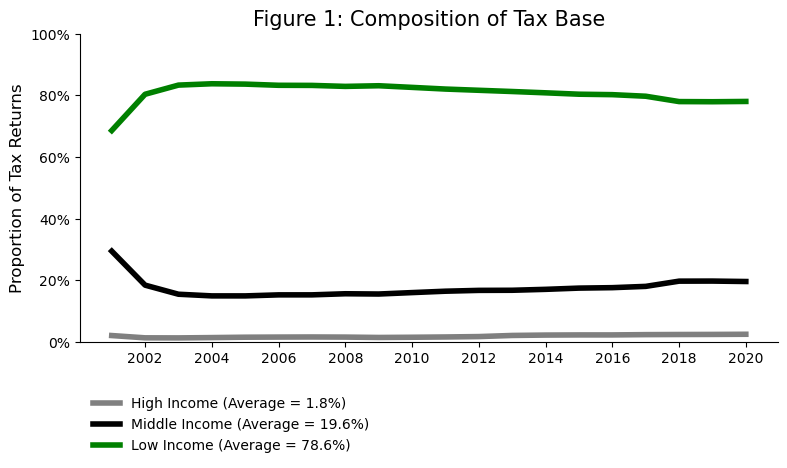

In [6]:
fig, ax = plt.subplots(figsize = (9,4))

# This gets the actual values of the proportions, this will be used for the ax.text code
props = taxes2.reset_index().groupby('tax_group').mean(numeric_only = True)['proportion_of_returns']

# Get post 2000 data
datause = taxes2.loc[taxes2['index'] > '2000']

# Legend labels will be used in renaming the legend, also assign colors.
    ## For readability, the averages of the legend color are included in the label instead of as text on the graph
legend_labels = {'lower bracket': 'Low Income (Average = {0:.1%})'.format(props[0]), 
                 'middle bracket': 'Middle Income (Average = {0:.1%})'.format(props[1]), 
                 'upper bracket': 'High Income (Average = {0:.1%})'.format(props[2])}
colors = ['grey', 'black', 'green']

# Order to have the legend in
group_order = ['upper bracket', 'middle bracket', 'lower bracket'] 

# Creates a line for each bracket type, and assigns color. Also adds a corresponding text with the average
for color, group in zip(colors, group_order):
    sns.lineplot(x='index', y = 'proportion_of_returns', data = datause.xs(group), 
                 label = group, color = color, alpha = 1,
                 linewidth = 4)

# Label the graph
ax.set_title('Figure 1: Composition of Tax Base', fontsize = 15)
ax.set_ylabel('Proportion of Tax Returns', fontsize = 12)
ax.set_xlabel('')

# Creates a handles/labels object that can be modified. This reorders the legend and recolors the legend
handles, labels = ax.get_legend_handles_labels()
ax.legend([handles[labels.index(group)] for group in group_order], [legend_labels[group] for group in group_order], 
         frameon = False, loc = 'lower left', bbox_to_anchor = (0, -.4))

# Set limit for percentages and despine
ax.set_ylim(0,1)
sns.despine(ax = ax)

# Set the format for the y axis
def percentage_formatter(x, pos):
    return f'{x * 100:.0f}%'
ax.yaxis.set_major_formatter(FuncFormatter(percentage_formatter))

plt.show()

### Figure 2: Create distribution bar plot

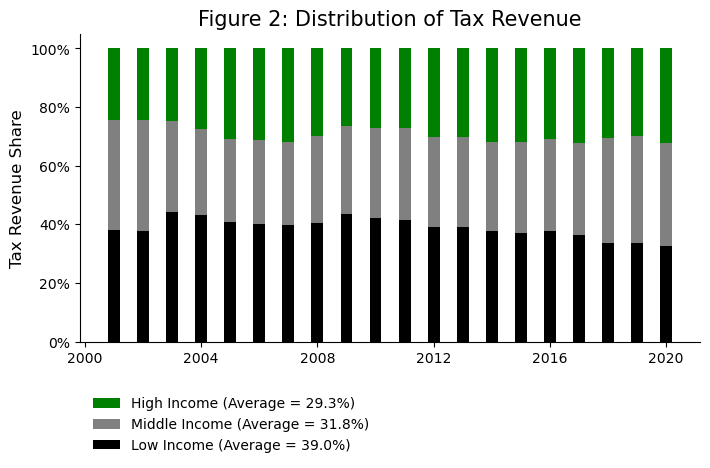

In [7]:
fig, ax = plt.subplots(figsize = (8,4))

bar_width = 150

# Sort data and assign group order
datause = taxes2.loc[taxes2['index'] > '2000']

# These are the values for the bar chart. Since each is different, looping didn't save much time
stackval = datause.loc[['lower bracket', 'middle bracket']].groupby('index').sum()['proportion_of_revenue']
val1 = datause.xs('lower bracket')['proportion_of_revenue']
val2 = datause.xs('middle bracket')['proportion_of_revenue']
val3 = datause.xs('upper bracket')['proportion_of_revenue']
index = datause.xs('lower bracket')['index']

# Assign groups, colors, and alpha
group_order = ['upper bracket', 'middle bracket', 'lower bracket'] 
colors = ['black', 'grey', 'green']
alpha = 1

# Create a bar plot for each group, stacking them with "bottom"
ax.bar(index, val1, label = group_order[2], width = bar_width, color = colors[0], alpha = alpha)
ax.bar(index, val2, label = group_order[1], bottom = val1 , width = bar_width, color = colors[1], alpha = alpha)
ax.bar(index, val3, label = group_order[0], bottom = stackval, width = bar_width, color = colors[2], alpha = alpha)

# Create an object with the mean proportional values. This will be used in teh legend labels below
means = datause.groupby('tax_group').mean(numeric_only=True)['proportion_of_revenue']

# Same code as above, orders and renames the legend labels
handles, labels = ax.get_legend_handles_labels()
legend_labels = {'lower bracket': 'Low Income (Average = {0:.1%})'.format(means[0]), 
                 'middle bracket': 'Middle Income (Average = {0:.1%})'.format(means[1]),
                 'upper bracket': 'High Income (Average = {0:.1%})'.format(means[2])}

ax.legend([handles[labels.index(label)] for label in group_order], [legend_labels[label] for label in group_order], 
          frameon = False, loc='lower left', bbox_to_anchor=(0, -.4))

# Uses formatter defined above to format y axis
ax.yaxis.set_major_formatter(FuncFormatter(percentage_formatter))

# Create labels
ax.set_title('Figure 2: Distribution of Tax Revenue', fontsize = 15)
ax.set_ylabel('Tax Revenue Share', fontsize = 12)
ax.set_xlabel('')
sns.despine(ax = ax)

plt.show()

### Figure 3: Creates average tax bill per filer bar plot

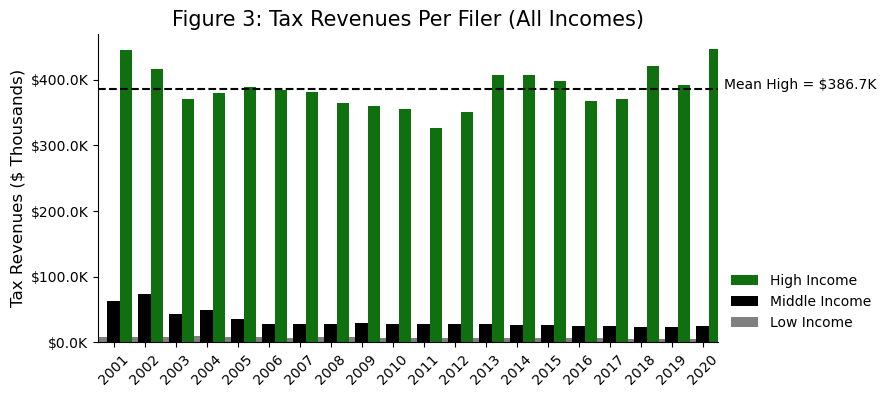

In [8]:
fig, ax = plt.subplots(figsize = (8,4))

# Load data and set alpha
datause = taxes2.reset_index()
datause = datause.loc[datause['index'] > '2000']
alpha = 1

# Plot a grouped bar plot, using tax_group as the grouping variable. Rotate the x-axis
sns.barplot(x= datause['index'].dt.year, y='tax_per_return', hue='tax_group', 
            data= datause, palette = ['grey', 'black', 'green'], 
            alpha = alpha,
            width = 1.2)

ax.tick_params(axis = 'x', which = 'major', rotation = 45)

# Create a variable for the mean of the upper bracket's average tax bill, and graph as a horizontal line
mean = datause.groupby('tax_group').mean(numeric_only = True)['tax_per_return']['upper bracket']
ax.axhline(mean, color = 'black', linestyle ='--')
ax.text(19.7, mean, s = 'Mean High = ${0:.1f}K'.format(mean/1000))
    
# Specify the desired order for the legend, same as above
handles, labels = ax.get_legend_handles_labels()
legend_labels = {'lower bracket': 'Low Income', 'middle bracket': 'Middle Income', 'upper bracket': 'High Income'}
group_order = ['upper bracket', 'middle bracket', 'lower bracket'] 
ax.legend([handles[labels.index(label)] for label in group_order], [legend_labels[label] for label in group_order], 
          frameon = False, loc='lower left', bbox_to_anchor=(1,0))

# Define a new y-axis formatter (for thousands) and format y-axis
thousands = FuncFormatter(lambda y, _: f"${y / 1e3:,.1f}K") 
ax.yaxis.set_major_formatter(thousands)

# Set labels
ax.set_title('Figure 3: Tax Revenues Per Filer (All Incomes)', fontsize = 15)
ax.set_ylabel('Tax Revenues ($ Thousands)', fontsize = 12)
ax.set_xlabel('')

sns.despine(ax = ax)
plt.show()

### Figure 4: Creates average tax bill for lower and middle income bar plot

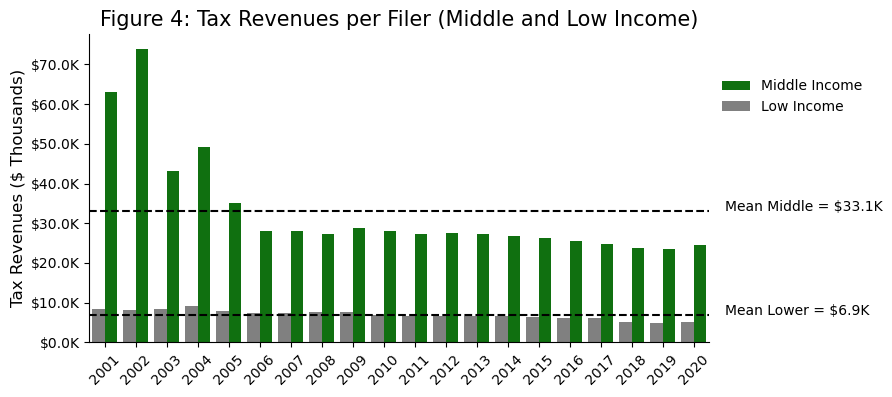

In [9]:
fig, ax = plt.subplots(figsize = (8,4))

# Define data. This specifically takes only lower and middle tax brackets
datause = taxes2.reset_index()
datause = datause.loc[(datause['index'] > '2000') & ~(datause['tax_group'] == 'upper bracket')]

# Plot the data as a bar plot (same as above). Rotate the x-axis
sns.barplot(x= datause['index'].dt.year, y='tax_per_return', hue='tax_group', data= datause, palette = ['grey', 'green'], alpha = 1)
ax.tick_params(axis = 'x', which = 'major', rotation = 45)

# Same as above, rename and reorder the legend
handles, labels = ax.get_legend_handles_labels()
legend_labels = {'lower bracket': 'Low Income', 'middle bracket': 'Middle Income', 'upper bracket': 'High Income'}
group_order = ['middle bracket', 'lower bracket'] 

ax.legend([handles[labels.index(label)] for label in group_order], [legend_labels[label] for label in group_order], 
          frameon = False, loc='lower left', bbox_to_anchor=(1, .7))

# Format y-axis (uses formatter above)
ax.yaxis.set_major_formatter(thousands)

# Create an average variable per group, a line per group, and a text label for the average per group
for group in group_order:
    mean = datause.groupby('tax_group').mean(numeric_only = True)['tax_per_return'][group]
    ax.axhline(mean, color = 'black', label = f'Mean ({group})', linestyle ='--')
    ax.text(20, mean, s = 'Mean {1} = ${0:.1f}K'.format(mean/1000, group.replace(' bracket','').title()))
    
# Label the axis
ax.set_title('Figure 4: Tax Revenues per Filer (Middle and Low Income)', fontsize = 15)
ax.set_ylabel('Tax Revenues ($ Thousands)', fontsize = 12)
ax.set_xlabel('')

sns.despine(ax = ax)
plt.show()

### Figure 5: Creates a laffer curve for all returns using a variation of weights

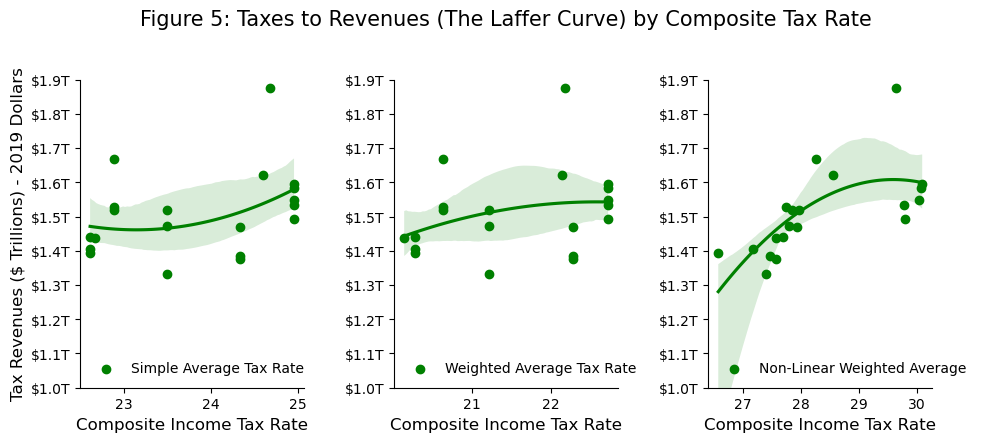

In [14]:
fig, ax = plt.subplots(1,3, figsize = (11,4))

# Sets width spacing between plots
fig.subplots_adjust(wspace=0.4)

# Load the data
datause = fred_merger(DataGrabber('All returns'))
datause.reset_index(inplace = True)
datause = datause.groupby('index').agg(agg_dict).reset_index()
datause = datause.loc[datause['index'] > '2000']

# Create a dictionary of label types
taxtypes = {'tax_rate': 'Simple Average Tax Rate', 'weighted_rate_basic': 'Weighted Average Tax Rate', 'weighted_rate': 'Non-Linear Weighted Average'}

# Create a laffer curve for the simple average tax rate and the weighted average tax rate
for i, rate in enumerate(['tax_rate', 'weighted_rate_basic', 'weighted_rate']):
    sns.regplot(x = rate, y='adjusted_tax_rev', 
           ax = ax[i],
           data = datause, 
           order=2, ci=90, 
           color = 'green',
           label = taxtypes[rate],
           scatter_kws={'alpha':1})
    
    # Format the y-axis to be in terms of billions of dollars
    formatter = FuncFormatter(lambda y, _: f"${y / 1e12:,.1f}T")  
    ax[i].yaxis.set_major_formatter(formatter)

    # Set labels
    ax[1].set_title("Figure 5: Taxes to Revenues (The Laffer Curve) by Composite Tax Rate", y = 1.15, fontsize = 15)
    ax[i].set_xlabel("Composite Income Tax Rate", fontsize = 12)
    sns.despine(ax = ax[i])
    ax[i].legend(frameon = False)

    ax[i].set_ylim(1000000000000, 1900000000000)
# Ensure the left y label is appropriate while disabling the right label
ax[0].set_ylabel("Tax Revenues ($ Trillions) - 2019 Dollars", fontsize = 12)
ax[1].set_ylabel("")
ax[2].set_ylabel("")

plt.show()

In [15]:
# Examines what proportion of tax revenue is generated by married filed jointly and single filer
   ## Note: This number is used in the analysis 
prop_married_single = (DataGrabber('Married Filed Jointly')['tax_generated'].sum() + DataGrabber('Single')['tax_generated'].sum()) / DataGrabber('All returns')['tax_generated'].sum()

print("Married Filed Jointly and Single Filer generate {0} of all tax revenues".format(f'{prop_married_single:.2%}'))

Married Filed Jointly and Single Filer generate 92.98% of all tax revenues


### Figure 6: Plot the laffer curves for different tax brackets

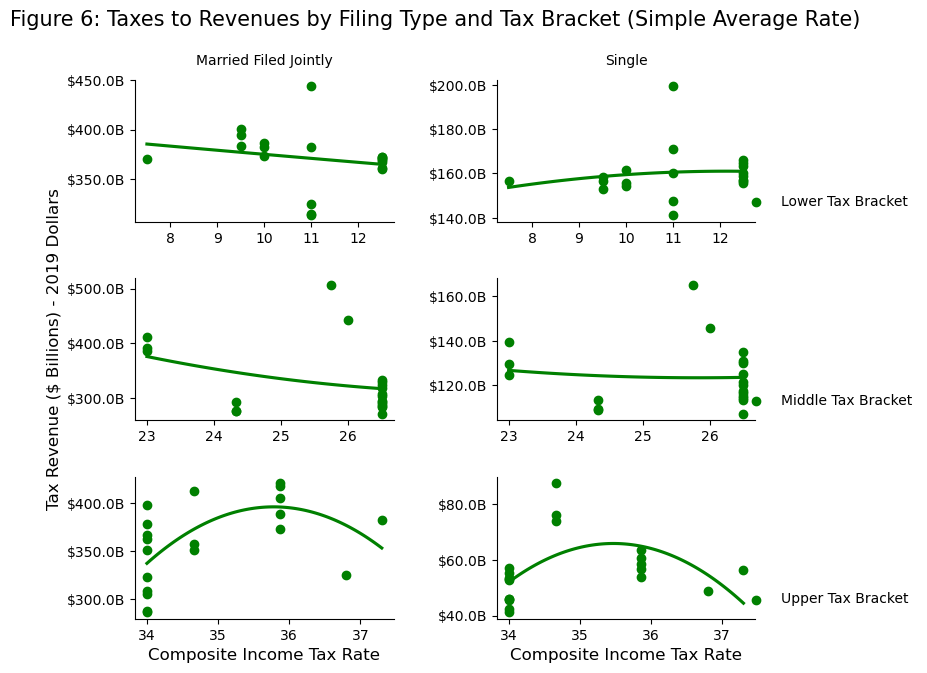

In [16]:

# Creates the figure and adjusts the height and width spacing
fig, ax = plt.subplots(3, 2, figsize = (8,7))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

plt.suptitle('Figure 6: Taxes to Revenues by Filing Type and Tax Bracket (Simple Average Rate)', fontsize=15)

# Creates an object to separate lower, middle, and upper bounds. Also, a time object so I can subset without grouping
bounds = [(0, 15, 'Lower Tax Bracket'), (16, 31, 'Middle Tax Bracket'), (32, 40, 'Upper Tax Bracket')]
times = ['2001','2020']

# Loop through bracket types (in the 'bounds' list) before looping through filing status. Note, axis are now arrays and require two coordinates
for i, bound in enumerate(bounds):
    for j, file_type in enumerate(['Married Filed Jointly', 'Single']):
        datause = fred_merger(DataGrabber(file_type, lower_bound = bound[0], upper_bound = bound[1]))
        datause = datause.loc[times[0]:times[1]]
        sns.regplot(x='tax_rate', y='adjusted_tax_rev', 
                   ax = ax[i][j],
                   data= datause, 
                   order=2, ci = None, 
                   label = bound[2],
                   color = 'green',
                   scatter_kws={'alpha':1})

        # Billion formatter and despiner
        formatter = FuncFormatter(lambda y, _: f"${y / 1e9:,.1f}B")  # Convert to millions and format as dollars
        ax[i][j].yaxis.set_major_formatter(formatter)
        sns.despine(ax = ax[i][j])

        # This disables most of the labels to prevent unnecessary clutter 
            ## Note: Some of the indices are hard coded to ensure compliance. They are not all meant to loop
        ax[0][j].set_ylabel('')
        ax[1][1].set_ylabel('')
        ax[1][0].set_ylabel('Tax Revenue ($ Billions) - 2019 Dollars', fontsize = 12)
        ax[2][j].set_ylabel('')
        ax[0][j].set_xlabel('')
        ax[1][j].set_xlabel('')
        ax[2][j].set_xlabel('Composite Income Tax Rate', fontsize = 12)
        ax[0][j].set_title('{0}'.format(file_type), fontsize = 10, y = 1.05)
    
    # Set the legend
    ax[i][1].legend(frameon = False, loc = 'lower left', bbox_to_anchor = (.9, 0))

plt.show()

### Figure 7: Create regression model

In [17]:
# Create a subset of the taxes2 dataframe from above as the regression data
regdata = taxes2.loc[taxes2['index'] > '2000'].copy()

# Define fixed effects for bracket type, and a list of brackets
fe = ['lower_fe', 'middle_fe', 'upper_fe']
brackets = ['lower bracket', 'middle bracket', 'upper bracket']

# Creates fixed effects per bracket type by creating new columns in reg data called 'lower_fe' etc with 1 or 0 as values
for fe, bracket in zip(fe, brackets):
    regdata[fe] = [1 if regdata.index[i] == bracket else 0 for i in range(len(regdata.index))]

# Create a series of fixed effects for year (creates variables called 'year_20??' etc)
years = [str(year) for year in range(2001, 2021, 1)]
for year in years:
    regdata['year_' + year] = [1 if regdata['index'][i] == pd.to_datetime(year) else 0 for i in range(len(regdata.index))]   

# Reset the index and set the new index as year and tax_group observations
regdata.reset_index(inplace = True)
regdata.set_index(['index', 'tax_group'], inplace = True)

# Create fixed effects for year by generating dummies as a long string of text
    ## Note: Due to multicolinearity, both 2001 and 2002 are omitted
yearstring = 'C(year_2003)'
for year in years[2:]:
    yearstring = yearstring + ' + ' 'C(year_{0})'.format(year)

# Define a string of variables for the regression. 
    ## NOTE: My analysis references OLS for both weighted_rate_basic, tax_rate, and weighted_rate, all you need to do is change the X1 variable in this string
string = 'adjusted_tax_rev ~ tax_rate + number_of_returns + income_taxed + C(lower_fe) + C(middle_fe) + GDPC1'

# Add the year fixed effects string to the variables string
variables = string + ' + ' + yearstring

# Generate a tax model using the variables string
tax_model = smf.ols(variables, data= regdata).fit()

# Assign values and shift them into a data frame
values = pd.DataFrame(tax_model.fittedvalues)

# Re-order the taxes2 data and merge into the values data. Finally, you rename the columns. This leaves a nice data frame with true and estimated values
datause = taxes2.reset_index()
datause = datause.loc[datause['index'] > '2000']
datause = pd.DataFrame(datause.set_index(['index', 'tax_group'])['adjusted_tax_rev'])
regdatatot = pd.merge(datause, values, left_index = True, right_index = True, how = 'inner')
regdatatot.reset_index(inplace = True)
regdatatot.columns = ['index', 'tax_group', 'adjusted_tax_rev', 'estimate']

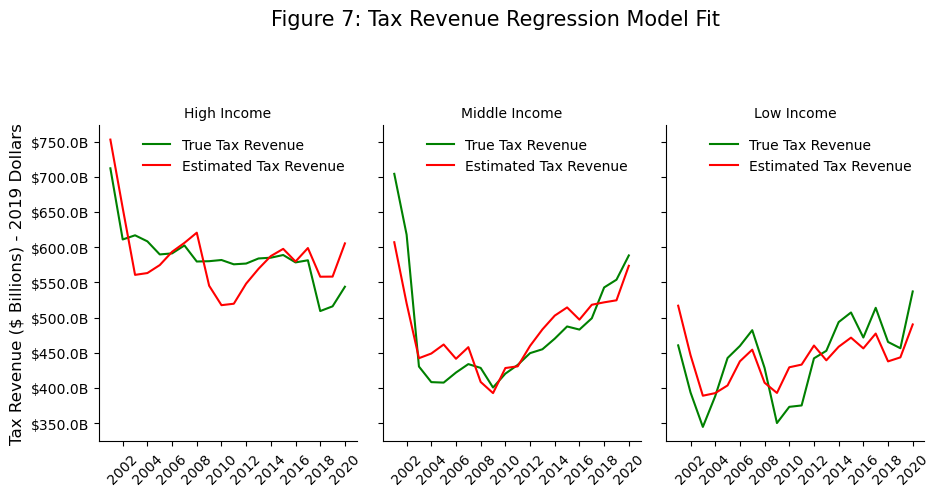

In [18]:
# Create a facet plot grid object separated by tax group as the columns
g = sns.FacetGrid(regdatatot, col = 'tax_group')

plt.suptitle('Figure 7: Tax Revenue Regression Model Fit', fontsize=15)

# Assign alpha
alpha = 1

# Create two lineplots graphing both the true and the estimated values
g.map(sns.lineplot, str('index'), 'adjusted_tax_rev', color = 'green', label = 'True Tax Revenue', alpha = alpha)
g.map(sns.lineplot, str('index'), 'estimate', color = 'red', label = 'Estimated Tax Revenue', alpha = alpha)

# For both plots, adjust the x axis, remove the x label, and assign a legend
for ax in g.axes.flat:
    ax.tick_params(axis='x', rotation=45)
    ax.set_xlabel('')
    ax.legend(frameon = False)

# For the left most graph assign the y-axis title
g.axes[0][0].set_ylabel('Tax Revenue ($ Billions) - 2019 Dollars', fontsize = 12)

# Define the group order and create a title using the group order and legend label dictionary from above
group_order = ['upper bracket', 'middle bracket', 'lower bracket'] 
for i, bracket in enumerate(group_order):
    g.axes[0][i].set_title('{0}'.format(legend_labels[bracket].title()), fontsize = 10)

# Control the height of the plots
g.fig.set_figheight(5.5)  

# Use a billion formatter for the y-axis
def billion_formatter(x, pos):
    return f'${x/1000000000:,.1f}B'
ax.yaxis.set_major_formatter(FuncFormatter(billion_formatter))

plt.show()

In [19]:
# Generate the model summary. I get the coefficient values quoted in the analysis from this code
    ## As mentioned above, this table can change depending on which X1 variable you use in the OLS regression
    ## I toggled through the three different tax rate types in order to get the coefficients I needed. Currently, it's tax_rate
tax_model.params

Intercept            6.405806e+12
C(lower_fe)[T.1]    -3.580215e+11
C(middle_fe)[T.1]   -1.725736e+11
C(year_2003)[T.1]    1.335405e+10
C(year_2004)[T.1]    2.185889e+11
C(year_2005)[T.1]    4.199672e+11
C(year_2006)[T.1]    6.108480e+11
C(year_2007)[T.1]    7.439745e+11
C(year_2008)[T.1]    7.018832e+11
C(year_2009)[T.1]    5.327833e+11
C(year_2010)[T.1]    7.241805e+11
C(year_2011)[T.1]    8.202782e+11
C(year_2012)[T.1]    9.872721e+11
C(year_2013)[T.1]    1.140643e+12
C(year_2014)[T.1]    1.319335e+12
C(year_2015)[T.1]    1.520989e+12
C(year_2016)[T.1]    1.623654e+12
C(year_2017)[T.1]    1.811920e+12
C(year_2018)[T.1]    1.944596e+12
C(year_2019)[T.1]    2.123952e+12
C(year_2020)[T.1]    2.016033e+12
tax_rate            -2.486777e+10
number_of_returns   -1.726147e+02
income_taxed        -2.404232e+01
GDPC1               -3.475800e+08
dtype: float64

### Appendix A: Figures 6a and b 

This code is just copied from the Figure 6 from above, except the x = 'tax_rate' line is changed to 'weighted_rate' and 'weighted_rate_basic'

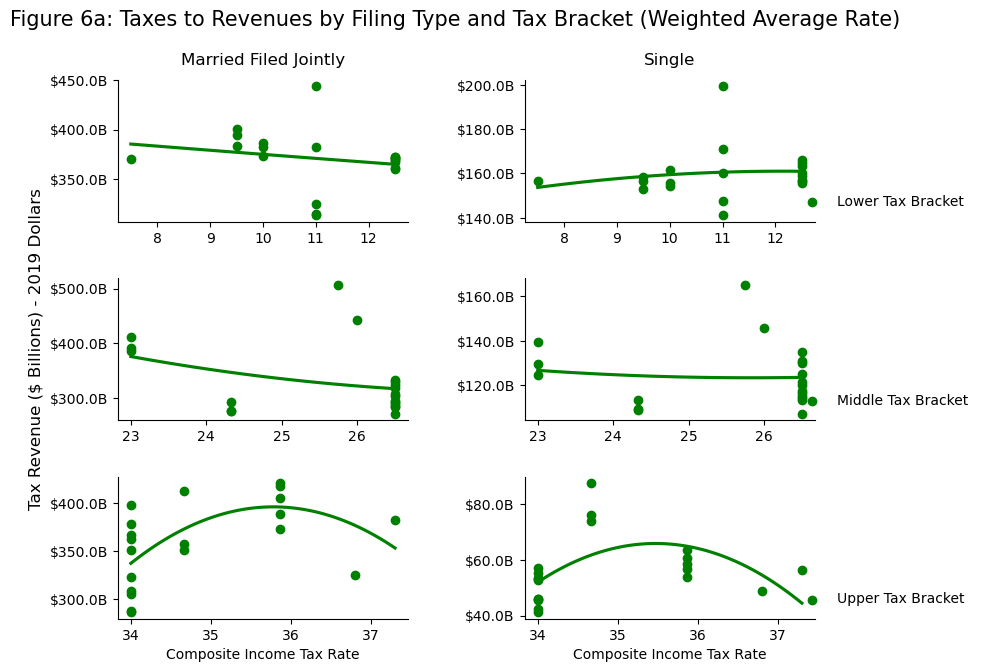

In [20]:
# Creates the figure and adjusts the height and width spacing
fig, ax = plt.subplots(3, 2, figsize = (9,7))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

plt.suptitle('Figure 6a: Taxes to Revenues by Filing Type and Tax Bracket (Weighted Average Rate)', fontsize=15)

# Creates an object to separate lower, middle, and upper bounds. Also, a time object so I can subset without grouping
bounds = [(0, 15, 'Lower Tax Bracket'), (16, 31, 'Middle Tax Bracket'), (32, 40, 'Upper Tax Bracket')]
times = ['2001','2020']

# Loop through bracket types (in the 'bounds' list) before looping through filing status. Note, axis are now arrays and require two coordinates
for i, bound in enumerate(bounds):
    for j, file_type in enumerate(['Married Filed Jointly', 'Single']):
        datause = fred_merger(DataGrabber(file_type, lower_bound = bound[0], upper_bound = bound[1]))
        datause = datause.loc[times[0]:times[1]]
        sns.regplot(x='weighted_rate_basic', y='adjusted_tax_rev', 
                   ax = ax[i][j],
                   data= datause, 
                   order=2, ci = None, 
                   label = bound[2],
                   color = 'green',
                   scatter_kws={'alpha':1})

        # Billion formatter and despiner
        formatter = FuncFormatter(lambda y, _: f"${y / 1e9:,.1f}B")  # Convert to millions and format as dollars
        ax[i][j].yaxis.set_major_formatter(formatter)
        sns.despine(ax = ax[i][j])

        # This disables most of the labels to prevent unnecessary clutter 
            ## Note: Some of the indices are hard coded to ensure compliance. They are not all meant to loop
        ax[0][j].set_ylabel('')
        ax[1][1].set_ylabel('')
        ax[1][0].set_ylabel('Tax Revenue ($ Billions) - 2019 Dollars', fontsize = 12)
        ax[2][j].set_ylabel('')
        ax[0][j].set_xlabel('')
        ax[1][j].set_xlabel('')
        ax[2][j].set_xlabel('Composite Income Tax Rate', fontsize = 10)
        ax[0][j].set_title('{0}'.format(file_type), fontsize = 12, y = 1.05)
    
    # Set the legend
    ax[i][1].legend(frameon = False, loc = 'lower left', bbox_to_anchor = (.9, 0))

plt.show()

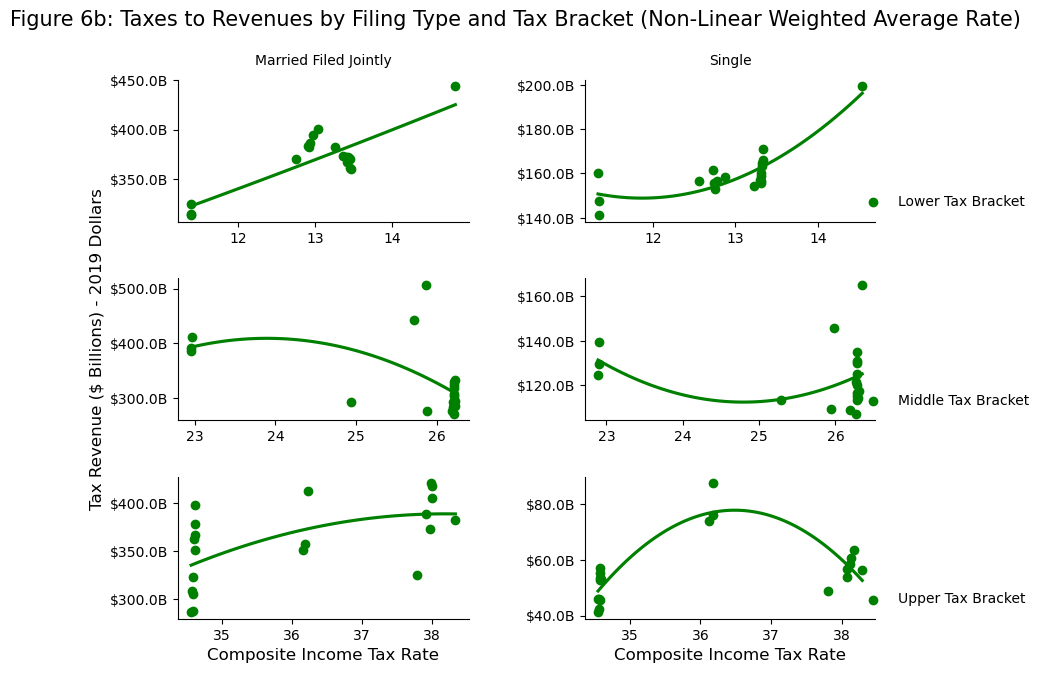

In [21]:

# Creates the figure and adjusts the height and width spacing
fig, ax = plt.subplots(3, 2, figsize = (9,7))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

plt.suptitle('Figure 6b: Taxes to Revenues by Filing Type and Tax Bracket (Non-Linear Weighted Average Rate)', fontsize=15)

# Creates an object to separate lower, middle, and upper bounds. Also, a time object so I can subset without grouping
bounds = [(0, 15, 'Lower Tax Bracket'), (16, 31, 'Middle Tax Bracket'), (32, 40, 'Upper Tax Bracket')]
times = ['2001','2020']

# Loop through bracket types (in the 'bounds' list) before looping through filing status. Note, axis are now arrays and require two coordinates
for i, bound in enumerate(bounds):
    for j, file_type in enumerate(['Married Filed Jointly', 'Single']):
        datause = fred_merger(DataGrabber(file_type, lower_bound = bound[0], upper_bound = bound[1]))
        datause = datause.loc[times[0]:times[1]]
        sns.regplot(x='weighted_rate', y='adjusted_tax_rev', 
                   ax = ax[i][j],
                   data= datause, 
                   order=2, ci = None, 
                   label = bound[2],
                   color = 'green',
                   scatter_kws={'alpha':1})

        # Billion formatter and despiner
        formatter = FuncFormatter(lambda y, _: f"${y / 1e9:,.1f}B")  # Convert to millions and format as dollars
        ax[i][j].yaxis.set_major_formatter(formatter)
        sns.despine(ax = ax[i][j])

        # This disables most of the labels to prevent unnecessary clutter 
            ## Note: Some of the indices are hard coded to ensure compliance. They are not all meant to loop
        ax[0][j].set_ylabel('')
        ax[1][1].set_ylabel('')
        ax[1][0].set_ylabel('Tax Revenue ($ Billions) - 2019 Dollars', fontsize = 12)
        ax[2][j].set_ylabel('')
        ax[0][j].set_xlabel('')
        ax[1][j].set_xlabel('')
        ax[2][j].set_xlabel('Composite Income Tax Rate', fontsize = 12)
        ax[0][j].set_title('{0}'.format(file_type), fontsize = 10, y = 1.05)
    
    # Set the legend
    ax[i][1].legend(frameon = False, loc = 'lower left', bbox_to_anchor = (.9, 0))

plt.show()

### Appendix B

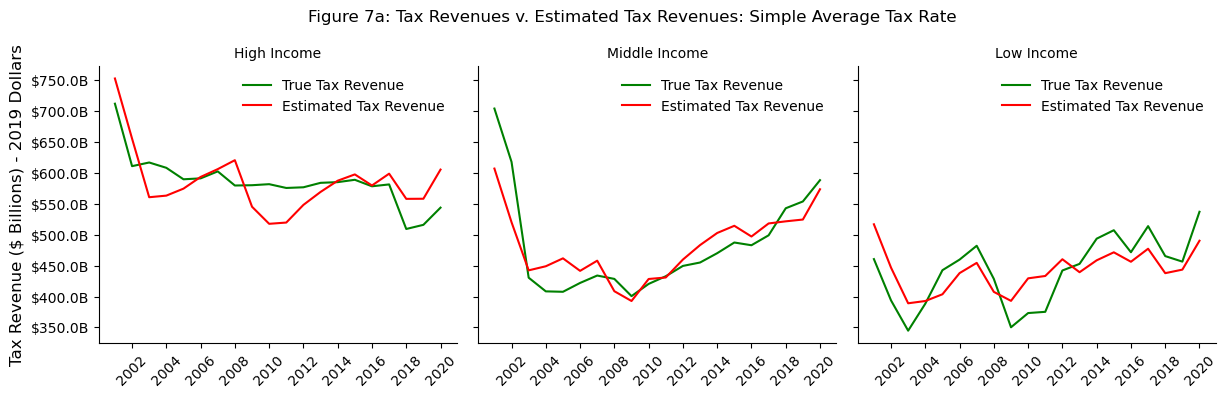

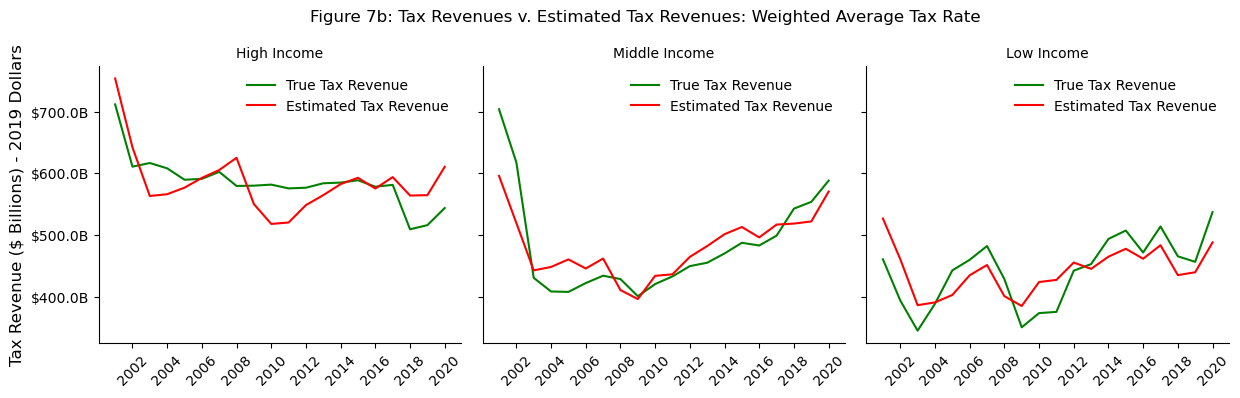

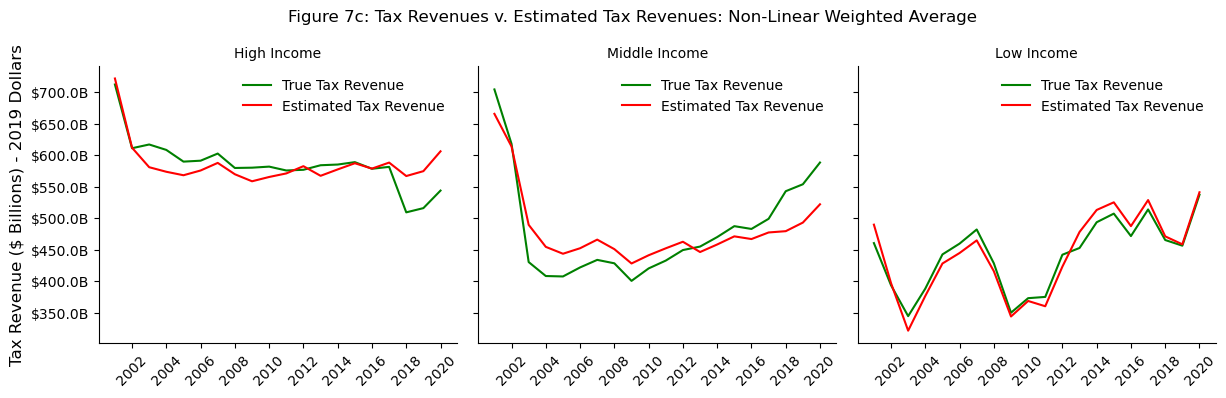

In [22]:
taxtypes = {'tax_rate': 'Simple Average Tax Rate', 'weighted_rate_basic': 'Weighted Average Tax Rate', 'weighted_rate': 'Non-Linear Weighted Average'}
for letter, indvar in zip(['a','b','c'], ['tax_rate', 'weighted_rate_basic', 'weighted_rate']):
# Create a subset of the taxes2 dataframe from above as the regression data
    regdata = taxes2.loc[taxes2['index'] > '2000'].copy()

    # Define fixed effects for bracket type, and a list of brackets
    fe = ['lower_fe', 'middle_fe', 'upper_fe']
    brackets = ['lower bracket', 'middle bracket', 'upper bracket']

    # Creates fixed effects per bracket type by creating new columns in reg data called 'lower_fe' etc with 1 or 0 as values
    for fe, bracket in zip(fe, brackets):
        regdata[fe] = [1 if regdata.index[i] == bracket else 0 for i in range(len(regdata.index))]

    # Create a series of fixed effects for year (creates variables called 'year_20??' etc)
    years = [str(year) for year in range(2001, 2021, 1)]
    for year in years:
        regdata['year_' + year] = [1 if regdata['index'][i] == pd.to_datetime(year) else 0 for i in range(len(regdata.index))]   

    # Reset the index and set the new index as year and tax_group observations
    regdata.reset_index(inplace = True)
    regdata.set_index(['index', 'tax_group'], inplace = True)

    # Create fixed effects for year by generating dummies as a long string of text
        ## Note: Due to multicolinearity, both 2001 and 2002 are omitted
    yearstring = 'C(year_2003)'
    for year in years[2:]:
        yearstring = yearstring + ' + ' 'C(year_{0})'.format(year)

    # Define a string of variables for the regression. 
        ## NOTE: My analysis references OLS for both weighted_rate_basic, tax_rate, and weighted_rate, all you need to do is change the X1 variable in this string
    string = 'adjusted_tax_rev ~ {0} + number_of_returns + income_taxed + C(lower_fe) + C(middle_fe) + GDPC1'.format(indvar)

    # Add the year fixed effects string to the variables string
    variables = string + ' + ' + yearstring

    # Generate a tax model using the variables string
    tax_model = smf.ols(variables, data= regdata).fit()

    # Assign values and shift them into a data frame
    values = pd.DataFrame(tax_model.fittedvalues)

    # Re-order the taxes2 data and merge into the values data. Finally, you rename the columns. This leaves a nice data frame with true and estimated values
    datause = taxes2.reset_index()
    datause = datause.loc[datause['index'] > '2000']
    datause = pd.DataFrame(datause.set_index(['index', 'tax_group'])['adjusted_tax_rev'])
    regdatatot = pd.merge(datause, values, left_index = True, right_index = True, how = 'inner')
    regdatatot.reset_index(inplace = True)
    regdatatot.columns = ['index', 'tax_group', 'adjusted_tax_rev', 'estimate']

    
    
    # Create a facet plot grid object separated by tax group as the columns
    g = sns.FacetGrid(regdatatot, col = 'tax_group', height = 4)

    plt.suptitle('Figure 7{1}: Tax Revenues v. Estimated Tax Revenues: {0}'.format(taxtypes[indvar], letter), fontsize=12)

    # Assign alpha
    alpha = 1

    # Create two lineplots graphing both the true and the estimated values
    g.map(sns.lineplot, str('index'), 'adjusted_tax_rev', color = 'green', label = 'True Tax Revenue', alpha = alpha)
    g.map(sns.lineplot, str('index'), 'estimate', color = 'red', label = 'Estimated Tax Revenue', alpha = alpha)

    # For both plots, adjust the x axis, remove the x label, and assign a legend
    for ax in g.axes.flat:
        ax.tick_params(axis='x', rotation=45)
        ax.set_xlabel('')
        ax.legend(frameon = False)

    # For the left most graph assign the y-axis title
    g.axes[0][0].set_ylabel('Tax Revenue ($ Billions) - 2019 Dollars', fontsize = 12)

    
    # Define the group order and create a title using the group order and legend label dictionary from above
    group_order = ['upper bracket', 'middle bracket', 'lower bracket'] 
    for i, bracket in enumerate(group_order):
        g.axes[0][i].set_title('{0}'.format(legend_labels[bracket].title()), fontsize = 10)

    # Use a billion formatter for the y-axis
    def billion_formatter(x, pos):
        return f'${x/1000000000:,.1f}B'
    ax.yaxis.set_major_formatter(FuncFormatter(billion_formatter))

    plt.show()